# Notebook 4: Topic Modeling, Parts of Speech Analysis

## Introduction

This notebook takes the speech transcripts that were scraped and cleaned in Notebooks 1-3, and simplifies each transcript into a bag-of-words, to use for topic modeling and parts of speech analysis.

In [1]:
import pickle
import pandas as pd
import numpy as np
import re
import string
from pprint import pprint
import matplotlib.pyplot as plt

import spacy
from spacy.symbols import amod

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF

from collections import Counter

#To use spaCy, I need to download and reference a language model.
sp = spacy.load('/opt/anaconda3/envs/metis/lib/python3.7/site-packages/en_core_web_sm/en_core_web_sm-2.2.5')

In [2]:
with open('../data/combined.pickle','rb') as read_file:
    ny = pickle.load(read_file)

## Data Pre-Processing

### Additional Data Cleaning

In [3]:
alphanumeric = lambda x: re.sub('\w*\d\w*', '', x)
punc = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
remove_space = lambda x: x.replace('  ', ' ')

In [4]:
ny['for_spacy'] = (ny['monologue']
                   .map(alphanumeric)
                   .map(punc)
                   .map(remove_space))
ny['spacy_monologue'] = ny['for_spacy'].map(lambda x: sp(x))

In [40]:
ny.iloc[21, :]

speaker                                                        cuomo
date                                             2020-04-30 00:00:00
link               https://www.governor.ny.gov/news/audio-rush-tr...
text               Susan Richard: Are you with us, Governor?Gover...
monologue          yes i am. how are you susan?susan yes i am. it...
for_spacy          yes i am how are you susan susan yes i am its ...
spacy_monologue    (yes, i, am, how, are, you, susan, susan, yes,...
lemmatized         yes i be how be you susan susan yes i be its a...
Name: 21, dtype: object

### Lemmatization

In [10]:
ny['lemmatized'] = (ny['spacy_monologue']
                    .map(lambda x: [' '.join(word.lemma_ 
                                             if word.lemma_ != '-PRON-' 
                                             else word.text 
                                             for word in x)][0]))

### Count Vectorization

I had to add several names to the stop words list because several of the transcripts had the names of interviewers.

In [11]:
my_stop_words = (text
                 .ENGLISH_STOP_WORDS
                 .union(['lehrer', 'brian', 'darden', 'moderator', 'alan', 
                         'howard', 'wolf', 'blitzer', 'errol', 'louis', 
                         'alisyn', 'chris', 'camerota', 'dan', 'mannarino',
                         'john', 'berman', 'savannah', 'guthrie', 'hoda']))

In [12]:
# Setting max_df to 0.5 and min_df = 2 because these provided the best topics
cv1 = CountVectorizer(stop_words = my_stop_words, max_df = 0.5, min_df=2)
docterm_matrix = cv1.fit_transform(ny.loc[:, 'lemmatized'])

In [13]:
doc_label = ['Document' + str(t) for t in range(len(ny.loc[:, 'lemmatized']))]

This creates a table with documents in the rows, and words (or terms) in the columns. The values refer to the number of times the term appears in the document.

In [14]:
pd.DataFrame(docterm_matrix.toarray(), index=doc_label, columns=cv1.get_feature_names()).iloc[:10, 630:650]

,bit,bite,bitta,bitter,bizarre,black,blackout,blame,blank,blanket,blare,blasio,bleach,blend,bless,blessed,blessing,blight,blip,blizzard
Document0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Document1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Document2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Document3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Document4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Document5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
Document6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Document7,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
Document8,1,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0
Document9,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


## Topic Modeling

### Using Non-Negative Matrix Factorization (NMF)

The code below uses NMF for 12 topics, but I tried a variety of different hyperparameters (including setting max_df and min_df in count_vectorizer) before settling on 12, which provided the clearest, most distinct topics.

In [22]:
nmf_cv = NMF(12)
nmf_topics1 = nmf_cv.fit_transform(docterm_matrix)

In [23]:
topicword_cv1 = pd.DataFrame(nmf_cv.components_.round(3),
                            index = ['topic0', 'topic1', 'topic2', 'topic3',
                                     'topic4', 'topic5', 'topic6', 'topic7',
                                     'topic8', 'topic9', 'topic10', 'topic11'],
                            columns = cv1.get_feature_names()) 

This creates a dataframe with the twelve topics in the rows, and the terms in the columns. The values in the dataframe describe how the term relates to the topic, with higher values indicating a stronger relationship.

In [24]:
topicword_cv1.iloc[:, 1790:1820]

,discussion,disdainful,disease,disgust,disgusting,dish,disinfect,disinfectant,disinvestment,dislike,...,displacement,display,disposal,disproportionate,disproportionately,dispute,disqualify,disregard,disrespect,disrespectful
topic0,0.232,0.004,6.028,0.000,0.019,0.000,0.000,0.000,0.029,0.000,...,0.000,0.082,0.000,0.069,0.038,0.001,0.000,0.000,0.000,0.000
topic1,0.180,0.000,0.065,0.015,0.007,0.011,0.484,0.010,0.000,0.001,...,0.000,0.000,0.000,0.023,0.070,0.016,0.012,0.009,0.004,0.032
topic2,0.088,0.000,0.509,0.014,0.001,0.000,0.000,0.000,0.000,0.000,...,0.001,0.000,0.000,0.004,0.000,0.015,0.000,0.000,0.000,0.044
topic3,0.178,0.000,3.368,0.000,0.000,0.000,0.000,0.010,0.000,0.000,...,0.000,0.000,0.000,0.000,0.021,0.000,0.017,0.000,0.024,0.022
topic4,0.309,0.000,0.000,0.019,0.010,0.000,0.000,0.004,0.001,0.006,...,0.010,0.000,0.000,0.005,0.000,0.000,0.000,0.006,0.000,0.000
topic5,0.115,0.000,0.000,0.007,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.009,0.001,0.015,0.000,0.000,0.000,0.036,0.008
topic6,0.157,0.000,0.000,0.000,0.000,0.034,0.000,0.005,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
topic7,0.058,0.000,0.000,0.008,0.076,0.000,0.015,0.000,0.073,0.002,...,0.022,0.000,0.007,0.004,0.000,0.000,0.000,0.000,0.002,0.001
topic8,0.142,0.025,2.783,0.002,0.000,0.000,0.059,0.012,0.000,0.004,...,0.006,0.000,0.034,0.000,0.009,0.007,0.000,0.000,0.000,0.044
topic9,0.000,0.000,0.000,0.000,0.006,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.001,0.002,0.000,0.000,0.001,0.030,0.000,0.017


To better characterize each topic, I am returning the 10 terms that are most related to each topic, using the function below. For simplicity, I copied the function output and named it below.

In [25]:
def top_words_per_topic(model, terms, topic_names = None):
    for ix, topic in enumerate(nmf_cv.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic '",topic_names[ix],"'")
        print(", ".join([cv1.get_feature_names()[i] 
                         for i in topic.argsort()[:-10 - 1:-1]]))

In [28]:
#top_words_per_topic(nmf_topics1, cv1.get_feature_names())

### Topics and Terms

**Covid Mechanics:**  disease, phase, fight, support, information, effort, folk, dr, transmission, save

**Reopening Metrics:**  rate, virus, reopen, infection, business, infect, hospitalization, news, mask, covid

**Neighborhood Impact:**  business, small, clinic, support, commissioner, neighborhood, barbot, folk, address, crucial

**DOH Communication:**  commissioner, information, disease, barbot, okay, folk, symptom, ahead, contact, deputy

**Healthcare:**  medicaid, budget, percent, pay, billion, program, cost, local, million, increase

**Hospital Needs:**  supply, commissioner, dr, ventilator, katz, clear, personnel, military, barbot, ahead

**Education/School:**  kid, chancellor, child, parent, learn, educator, summer, support, moment, tough

**Neighborhood Resilience:**  applause, stop, young, save, kid, neighborhood, officer, fight, stand, apartment

**Homelessness:**  street, nypd, disease, safe, homeless, commissioner, face, term, police, fight

**Hospital Status:**  ventilator, bed, increase, percent, equipment, curve, positive, virus, apex, spread

**Hate Crime:**  attack, nation, law, progressive, build, stand, pass, job, history, hate

**New Yorkers:**  food, folk, clear, plan, safe, basic, focus, provide, fight, ago

### Create Variable for Topic in Dataframe

I want to put this all into a dataframe, with the speech transcript information, and the topic.

In [31]:
ny_docs_topics = ny.loc[:, ['speaker']]

In [32]:
ny_docs_topics

,speaker
0,cuomo
1,cuomo
2,cuomo
3,cuomo
4,cuomo
...,...
390,de blasio
391,de blasio
392,de blasio
393,de blasio


In [33]:
ny_docs_topics['topics12'] = nmf_topics1.argmax(axis = 1) #this is an array of which topic each document belongs to. 

Given these topics, I wanted to understand how speakers engaged with each topic, so I looked at overall counts by topic, and then split it up by speaker.

In [34]:
speaker_topics = pd.DataFrame(ny_docs_topics.groupby(['topics12']).speaker.value_counts())
speaker_topics.columns = ['count']
speaker_topics.reset_index()
speaker_topics_pivot = speaker_topics.reset_index().pivot_table(index = 'topics12', columns = 'speaker', values = 'count', fill_value = 0).reset_index(drop = True)
speaker_topics_pivot['total'] = speaker_topics_pivot['cuomo'] + speaker_topics_pivot['de blasio']
speaker_topics_pivot.sort_values('total', inplace = True)

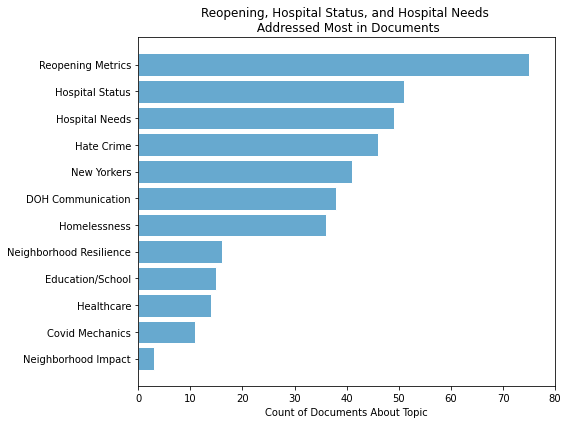

In [39]:
plt.figure(figsize = (8, 6))
names = list(set(speaker_topics_pivot.index))
barWidth= 0.85
plt.title('Reopening, Hospital Status, and Hospital Needs \n Addressed Most in Documents')
plt.xlabel('Count of Documents About Topic')
plt.xlim(0, 80)
plt.barh(names, speaker_topics_pivot['total'], color='#67a9cf', edgecolor='white', height=barWidth)
plt.yticks(range(0, 12), ['Neighborhood Impact', 'Covid Mechanics', 'Healthcare', 'Education/School', 
                         'Neighborhood Resilience', 'Homelessness', 'DOH Communication', 'New Yorkers',
                         'Hate Crime', 'Hospital Needs', 'Hospital Status', 'Reopening Metrics'])
plt.tight_layout()
plt.savefig('topics.pdf');

The topic that appears most frequently relates to metrics for reopening. This includes terms like rate, virus, reopen, infection, business, infect, and hospitalization. This makes sense, since at the end of May, counties were getting ready to re-open, and metrics were being monitored to determine readiness for Phase 1. 

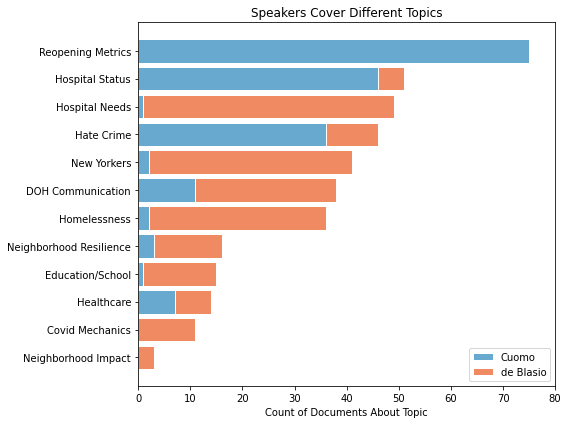

In [40]:
plt.figure(figsize = (8, 6))
names = list(set(speaker_topics_pivot.index))
barWidth= 0.85
plt.title('Speakers Cover Different Topics')
plt.xlabel('Count of Documents About Topic')
plt.xlim(0, 80)
plt.barh(names, speaker_topics_pivot['cuomo'], color='#67a9cf', edgecolor='white', height=barWidth, label = 'Cuomo')
plt.barh(names, speaker_topics_pivot['de blasio'], left =speaker_topics_pivot['cuomo'], color='#ef8a62', edgecolor='white', height=barWidth, label = 'de Blasio')
plt.yticks(range(0, 12), ['Neighborhood Impact', 'Covid Mechanics', 'Healthcare', 'Education/School', 
                         'Neighborhood Resilience', 'Homelessness', 'DOH Communication', 'New Yorkers',
                         'Hate Crime', 'Hospital Needs', 'Hospital Status', 'Reopening Metrics'])
plt.legend()
plt.tight_layout()
plt.savefig('speaker_topics.pdf');

Reopening is purely a Cuomo topic, which also makes sense - at the end of May, the only counties that have reopened are outside of NYC. Cuomo has also started a lot of his speeches by giving statistics relevant to reopening. de Blasio dominates the topic of hospital needs, whereas Cuomo discusses the status of hospitals. These describe different things, where Cuomo's speeches tend of involve updates on ventilators, beds and equipment available, and de Blasio addresses what NYC hospitals are missing: personnel, supplies, and ventilators. They are both covering hospitals in slightly different ways.

## Parts of Speech Analysis

Now I want to take a closer look at how they are speaking about certain topics. I used spaCy to analyze parts of speech, looking at adjective modifiers to understand how both speakers are talking about testing, hospitals, New Yorkers, the government, and care.

In [21]:
cuomo_speeches = ny[ny.speaker == 'cuomo']
de_blasio_speeches = ny[ny.speaker == 'de blasio']

In [22]:
def get_amods(noun, ser):
    amod_list = []
    for doc in ser:
        for token in doc:
            if (token.text) == noun:
                for child in token.children:
                    if child.dep == amod:
                        amod_list.append(child.text.lower())
    return sorted(amod_list)

In [23]:
def amods_returnlist(noun, speaker_speeches):
    return get_amods(noun, speaker_speeches.spacy_monologue)

### "Testing"

In [24]:
print('Cuomo - Top Adjective Modifiers:', Counter(amods_returnlist('testing', cuomo_speeches))
      .most_common(4))
print('de Blasio - Top Adjective Modifiers":', Counter(amods_returnlist('testing', de_blasio_speeches))
      .most_common(4))

Cuomo - Top Adjective Modifiers: [('more', 26), ('automated', 16), ('diagnostic', 14), ('own', 9)]
de Blasio - Top Adjective Modifiers": [('more', 70), ('widespread', 25), ('diagnostic', 14), ('automated', 10)]


There are a lot of similarities in how they describe testing: they both want more of it, they want it automated, and they want diagnostic testing.

### "Hospital"

In [25]:
print('Cuomo - Top Adjective Modifiers:', Counter(amods_returnlist('hospital', cuomo_speeches))
      .most_common(2))
print('de Blasio - Top Adjective Modifiers:', Counter(amods_returnlist('hospital', de_blasio_speeches))
      .most_common(2))

Cuomo - Top Adjective Modifiers: [('public', 6), ('temporary', 3)]
de Blasio - Top Adjective Modifiers: [('elmhurst', 44), ('public', 37)]


They both describe public hospitals, with de Blasio emphasizing Elmhurst, where a lot of Covid-19 cases were taken.

### "Yorkers"

In [26]:
print('Cuomo - Top Adjective Modifiers:', Counter(amods_returnlist('yorkers', cuomo_speeches))
      .most_common(10))
print('de Blasio - Top Adjective Modifiers:', Counter(amods_returnlist('yorkers', de_blasio_speeches))
      .most_common(10))

Cuomo - Top Adjective Modifiers: [('new', 234), ('many', 6), ('elderly', 2), ('fewer', 2), ('best', 1), ('connected', 1), ('correct', 1), ('enough', 1), ('fellow', 1), ('first', 1)]
de Blasio - Top Adjective Modifiers: [('new', 1239), ('fellow', 55), ('many', 45), ('everyday', 42), ('homeless', 15), ('more', 13), ('most', 4), ('vulnerable', 4), ('other', 3), ('working', 3)]


They describe different populations of New Yorkers: Cuomo focuses more on the elderly, and de Blasio spends more time discussing the homeless, vulnerable, and working class New Yorkers. 

### "Government"

In [27]:
print('Cuomo - Top Adjective Modifiers:', Counter(amods_returnlist('government', cuomo_speeches))
      .most_common(10))
print('de Blasio - Top Adjective Modifiers:', Counter(amods_returnlist('government', de_blasio_speeches))
      .most_common(10))

Cuomo - Top Adjective Modifiers: [('federal', 455), ('local', 22), ('progressive', 14), ('best', 3), ('active', 2), ('competent', 2), ('effective', 2), ('proper', 2), ('right', 2), ('thefederal', 2)]
de Blasio - Top Adjective Modifiers: [('federal', 593), ('national', 10), ('local', 6), ('entire', 3), ('american', 2), ('chinese', 2), ('iranian', 2), ('whole', 2), ('blown', 1), ('fight', 1)]


They both talk at length about the federal government, though Cuomo's assessment of the government tends to be a lot more positive than de Blasio's.

### "Care"

In [28]:
print('Cuomo - Top Adjective Modifiers:', Counter(amods_returnlist('care', cuomo_speeches))
      .most_common(10))
print('de Blasio - Top Adjective Modifiers:', Counter(amods_returnlist('care', de_blasio_speeches))
      .most_common(10))

Cuomo - Top Adjective Modifiers: [('appropriate', 6), ('intensive', 6), ('medical', 4), ('acute', 3), ('ambulatory', 2), ('alternative', 1), ('best', 1), ('compassionate', 1), ('good', 1), ('major', 1)]
de Blasio - Top Adjective Modifiers: [('medical', 28), ('universal', 13), ('urgent', 11), ('available', 10), ('intensive', 9), ('public', 8), ('guaranteed', 6), ('less', 5), ('more', 5), ('immediate', 4)]


de Blasio focuses on universal and available public care, whereas Cuomo focuses on appropraite and intensive care.

The parts-of-speech analysis highlights de Blasio's progressive roots, with his focus on working class New Yorkers, and the need for universal, public health care. 